# Neural Network
In this notebook, we are going to be focusing on the neural network module in PAI-Utils.


## Setup
First, we will need to import packages and get the Cifar10 dataset.

### Import Packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils.analytics import Analyzer
from paiutils import image
from paiutils import neural_network as nn

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Cifar10 Dataset
1. Download the Cifar10 dataset
2. Scale the images and create one hot encodings for the labels
3. Batch the datasets and create a dictionary of the data

In [2]:
# Get dataset
cifar = tfds.image_classification.Cifar10()
cifar.download_and_prepare()
print(cifar.info.features)
print(cifar.info.splits)
data = cifar.as_dataset()
num_train_examples = cifar.info.splits['train'].num_examples
num_classes = cifar.info.features['label'].num_classes

# Preprocess dataset
def preprocess(x):
    img, lbl = x['image'], x['label']
    img = tf.cast(img, tf.float32) / 255.0
    lbl = tf.one_hot(lbl, num_classes)
    return img, lbl
train_data = data['train'].map(preprocess)
val_data = data['test'].map(preprocess)
print(train_data)

# Batch the dataset and make dictionary
batch_size = 16
data = {'train': train_data.repeat().batch(batch_size),
        'validation': val_data.batch(batch_size)}
input_shape = train_data.element_spec[0].shape
output_shape = train_data.element_spec[1].shape

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
{'test': <tfds.core.SplitInfo num_examples=10000>, 'train': <tfds.core.SplitInfo num_examples=50000>}
<MapDataset shapes: ((32, 32, 3), (10,)), types: (tf.float32, tf.float32)>


## Analyze dataset
The dataset is a well-used dataset so we can assume the data is correctly labelled, but let us take a look at the data anyways.

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


<IPython.core.display.Javascript object>


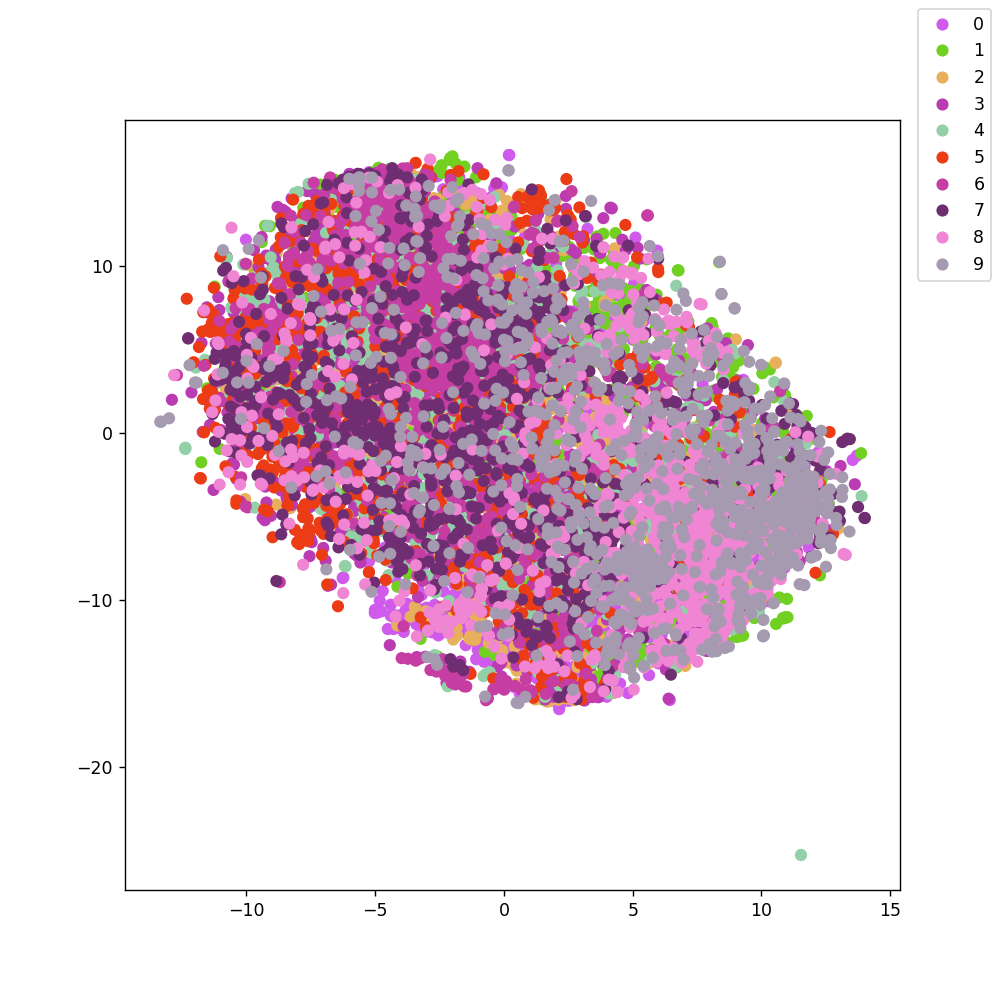

In [3]:
%matplotlib notebook

# Analyzer only works with ndarrays so converting
# dataset in to ndarray
np_train_data = train_data.batch(
    num_train_examples
).as_numpy_iterator().next()

# Create Analyzer
analyzer = Analyzer(np_train_data[0], np_train_data[1].argmax(axis=1), np.arange(10))

# Check how many images are for each label
print(analyzer.calculate_distribution_of_labels())

# Shrink data to visualize
analyzer = analyzer.shrink_data(1000)

# Visualize an embedding of the data
emb = analyzer.plot(analyzer.tsne(n_components=2, perplexity=200.0, n_jobs=-1))

We see one potential outlier in the embedding, so let us take a look at it.

[ 11.536079 -25.259275]
4139 10000
4
1000


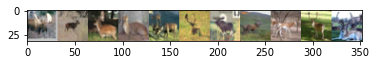

In [4]:
%matplotlib inline

# Find the outlier
# The method of finding the index
# may vary depending on where the outlier is
ndx = emb.argmin(axis=0)[1]
print(emb[ndx])
print(ndx, len(emb))
label = analyzer.y_data[ndx]
print(label)

# Compare to others in the group
groups = analyzer.create_label_ndx_groups()
imgs = [analyzer.x_data[ndx]]
print(len(groups[label]))
for ndx2 in groups[label][:10]:
    if ndx != ndx2:
        imgs.append(analyzer.x_data[ndx2])
plt.imshow(np.hstack(imgs))

The potential outlier it not super clear but it is valid, so let us move on.

## Create the model
We will now make a model that will be able to classify the images under one of the 10 labels.

In [5]:
x0 = keras.layers.Input(shape=input_shape)
# conv2d by default has a RELU activation and batch norm
x = nn.conv2d(64, kernel_size=3, strides=2)(x0)
x = nn.conv2d(128, 3, 2)(x)
x = nn.conv2d(256, 3, 2)(x)
x = nn.conv2d(512, 3, 2)(x)
x = keras.layers.Flatten()(x)
x = nn.dense(output_shape[0], activation='softmax', batch_norm=False)(x)

model = keras.Model(inputs=x0, outputs=x)
model.compile(optimizer=keras.optimizers.Adam(.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1728      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73728     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         294912    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)        

## Train the Model
We can now use the Trainer to train the model to predict the label given an image from the Cifar10 dataset.

In [6]:
steps_per_epoch = int(len(train_data) // batch_size)
trainer = nn.Trainer(model, data)
trainer.train(40, steps_per_epoch=steps_per_epoch)
path = trainer.save('')
trainer.eval(steps=100)

Epoch 1/40
3125/3125 [==============================] - 10s 3ms/step - loss: 1.5320 - accuracy: 0.4954 - val_loss: 2.6722 - val_accuracy: 0.3085
Epoch 2/40
3125/3125 [==============================] - 10s 3ms/step - loss: 0.9675 - accuracy: 0.6610 - val_loss: 1.0514 - val_accuracy: 0.6481
Epoch 3/40
3125/3125 [==============================] - 10s 3ms/step - loss: 0.6764 - accuracy: 0.7634 - val_loss: 1.0313 - val_accuracy: 0.6754
Epoch 4/40
3125/3125 [==============================] - 10s 3ms/step - loss: 0.4347 - accuracy: 0.8468 - val_loss: 1.5035 - val_accuracy: 0.6190
Epoch 5/40
3125/3125 [==============================] - 10s 3ms/step - loss: 0.3202 - accuracy: 0.8858 - val_loss: 1.4194 - val_accuracy: 0.6427
Epoch 6/40
3125/3125 [==============================] - 10s 3ms/step - loss: 0.2132 - accuracy: 0.9241 - val_loss: 1.6344 - val_accuracy: 0.6520
Epoch 7/40
3125/3125 [==============================] - 10s 3ms/step - loss: 0.1883 - accuracy: 0.9326 - val_loss: 1.6979 - val_ac

{'Train': [0.09706148505210876, 0.9693750143051147],
 'Validation': [2.4624135494232178, 0.715624988079071]}

## Create a More Advance Model
We did not get the greatest results with our simple model, so let us make a more advance one.

In [7]:
x0 = keras.layers.Input(shape=input_shape)
x = nn.conv2d(64, kernel_size=3, strides=2)(x0)

x = nn.inception([
    [nn.conv2d(96, 1, 1), nn.conv2d(128, 3)],
    [nn.conv2d(16, 1, 1), nn.conv2d(32, 5)],
    [nn.conv2d(64, 1, 1)],
])(x)
x = keras.layers.Concatenate()(x)
x = nn.inception([
    [nn.conv2d(96, 1, 1), nn.conv2d(128, 3)],
    [nn.conv2d(16, 1, 1), nn.conv2d(32, 5)],
    [nn.conv2d(64, 1, 1)],
])(x)
x = keras.layers.Concatenate()(x)
x = nn.inception([
    [nn.conv2d(96, 1, 1), nn.conv2d(256, 3, 2)],
    [nn.conv2d(16, 1, 1), nn.conv2d(64, 5, 2)],
    [keras.layers.MaxPooling2D(3, 2, padding='same')],
])(x)
x = keras.layers.Concatenate()(x)

x = nn.inception([
    [nn.conv2d(128, 1, 1), nn.conv2d(196, 3)],
    [nn.conv2d(32, 1, 1), nn.conv2d(64, 5)],
    [nn.conv2d(128, 1, 1)],
])(x)
x = keras.layers.Concatenate()(x)
x = nn.inception([
    [nn.conv2d(128, 1, 1), nn.conv2d(196, 3)],
    [nn.conv2d(32, 1, 1), nn.conv2d(64, 5)],
    [nn.conv2d(128, 1, 1)],
])(x)
x = keras.layers.Concatenate()(x)
x = nn.inception([
    [nn.conv2d(196, 1, 1), nn.conv2d(320, 3, 2)],
    [nn.conv2d(32, 1, 1), nn.conv2d(64, 5, 2)],
    [keras.layers.MaxPooling2D(3, 2, padding='same')],
])(x)
x = keras.layers.Concatenate()(x)

x = nn.inception([
    [nn.conv2d(196, 1, 1), nn.conv2d(256, 3)],
    [nn.conv2d(256, 1, 1)],
])(x)
x = keras.layers.Concatenate()(x)
x = nn.inception([
    [nn.conv2d(196, 1, 1), nn.conv2d(256, 3)],
    [nn.conv2d(256, 1, 1)],
])(x)
x = keras.layers.Concatenate()(x)
x = nn.inception([
    [nn.conv2d(228, 1, 1), nn.conv2d(320, 3, 2)],
    [keras.layers.MaxPooling2D(3, 2, padding='same')],
])(x)
x = keras.layers.Concatenate()(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = nn.dense(num_classes, activation='softmax', batch_norm=False)(x)

model2 = keras.Model(inputs=x0, outputs=x)
model2.compile(optimizer=keras.optimizers.Adam(.001), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   1728        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 96)   6144        batch_normalization_4[0][0]      
_______________________________________________________________________________________

## Train the Advance Model

In [8]:
steps_per_epoch = int(len(train_data) // batch_size)
trainer = nn.Trainer(model2, data)
trainer.train(40, steps_per_epoch=steps_per_epoch)
path = trainer.save('')
trainer.eval(steps=100)

Epoch 1/40
3125/3125 [==============================] - 39s 12ms/step - loss: 1.3791 - accuracy: 0.5196 - val_loss: 2.5743 - val_accuracy: 0.4541
Epoch 2/40
3125/3125 [==============================] - 38s 12ms/step - loss: 0.8603 - accuracy: 0.7023 - val_loss: 1.2028 - val_accuracy: 0.6757
Epoch 3/40
3125/3125 [==============================] - 38s 12ms/step - loss: 0.6489 - accuracy: 0.7755 - val_loss: 0.9532 - val_accuracy: 0.7210
Epoch 4/40
3125/3125 [==============================] - 38s 12ms/step - loss: 0.4880 - accuracy: 0.8317 - val_loss: 0.8615 - val_accuracy: 0.7374
Epoch 5/40
3125/3125 [==============================] - 38s 12ms/step - loss: 0.3573 - accuracy: 0.8764 - val_loss: 0.8620 - val_accuracy: 0.7646
Epoch 6/40
3125/3125 [==============================] - 38s 12ms/step - loss: 0.2626 - accuracy: 0.9071 - val_loss: 0.8344 - val_accuracy: 0.7813
Epoch 7/40
3125/3125 [==============================] - 38s 12ms/step - loss: 0.2054 - accuracy: 0.9260 - val_loss: 0.8293 -

{'Train': [0.16162508726119995, 0.9474999904632568],
 'Validation': [1.2356852293014526, 0.8006250262260437]}

## Test the Advance Model
We will test the advance model by using the Predictor to load the saved model and weights

In [10]:
path = 'trained_amodel'
predictor = nn.Predictor(path)

model
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   1728        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 96)   6144        batch_normalization_4[0][0]      
_________________________________________________________________________________

True label: horse - Pred label: bird - Pred: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


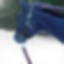

True label: airplane - Pred label: automobile - Pred: [0.29 0.37 0.   0.   0.   0.   0.   0.32 0.   0.02]


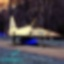

True label: frog - Pred label: frog - Pred: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


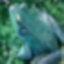

True label: truck - Pred label: truck - Pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


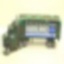

True label: dog - Pred label: dog - Pred: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


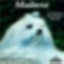

True label: automobile - Pred label: automobile - Pred: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


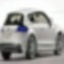

True label: horse - Pred label: horse - Pred: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


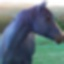

True label: airplane - Pred label: airplane - Pred: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


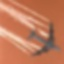

True label: cat - Pred label: dog - Pred: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


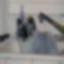

True label: bird - Pred label: deer - Pred: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


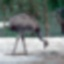

True label: horse - Pred label: horse - Pred: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


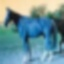

True label: bird - Pred label: bird - Pred: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


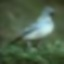

True label: horse - Pred label: horse - Pred: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


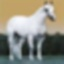

True label: truck - Pred label: truck - Pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


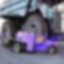

True label: frog - Pred label: dog - Pred: [0.   0.   0.05 0.   0.   0.94 0.   0.   0.   0.  ]


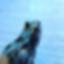

True label: ship - Pred label: airplane - Pred: [0.68 0.   0.   0.   0.   0.   0.   0.   0.19 0.13]


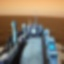

True label: ship - Pred label: bird - Pred: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


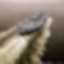

True label: ship - Pred label: ship - Pred: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


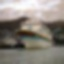

True label: horse - Pred label: horse - Pred: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


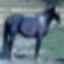

True label: truck - Pred label: truck - Pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


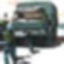

In [11]:
%matplotlib inline
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
example_data = val_data.take(20)
for example in example_data:
    x =  example[0].numpy()
    label = labels[example[1].numpy().argmax()]
    
    pred = predictor.predict(x)
    pred_label = labels[pred.argmax()]
    pred = np.round(pred, 2)
    
    x = x * 255.0
    print(f'True label: {label} - Pred label: {pred_label} - Pred: {pred}')
    ret = image.cv2.imencode('.jpg', image.pyr(x, 1))[1]
    display(Image(data=ret))

Although the model is not completely accurate, it still shows the incredible ability of deep networks to classify images.